# Accessing and using an icechunk store on PO.DAAC

#### *This notebook is meant to be run in the cloud, e.g. on a VM in AWS*

This notebook demonstrates obtaining a zipped icechunk store on a publicly available URL from PO.DAAC and using it to open a PO.DAAC data set and perform some computations. The data set is CCMP 6-hourly L4 winds.

**This notebook demonstrates two key results**

1. We can store icechunk stores on PO.DAAC's gitlab and access / use them succesfully. Computation times are the same as using a kerchunk JSON so far.
2. The kerchunk JSON is also access / used for comparison and we are able to succeffully load it with the most recent versions of zarr, virtualizarr, kerchunk. This demonstrates that we can utilize both JSON and icechunk formats using the same python environment and package versions.

In [1]:
# Built-in packages
import os
import sys
import shutil
from typing import Optional

# Filesystem management 
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import icechunk

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Functions to add in earthaccess

Currently very hacky, but simulates getting a zipped icechunk store from PO.DAAC via https, downloading it locally, unzipping, and passing back an icechunk store object for use with `xarray.open_dataset()`

In [8]:
def open_icechunk(store_url):
    """
    """
    import earthaccess
    import requests
    import fsspec
    import xarray as xr
    import zipfile

    
    ## Download and unzip icechunk store from PO.DAAC:
    r = requests.get(store_url)
    fname_store = store_url.split("/")[-1]
    _ = open(fname_store, 'wb').write(r.content)
    fname_store_unzip = fname_store.split(".zip")[0]
    with zipfile.ZipFile(fname_store, 'r') as zip_ref:
        zip_ref.extractall("./"+fname_store_unzip)
        
    
    ## Access repo with earthaccess credentials added:
    ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')
    repo = get_icechunk_repo_local(repo_path=fname_store_unzip, ea_creds=ea_creds)
    session = repo.readonly_session(branch="main")

    return session.store


def get_icechunk_repo_local(repo_path: str, ea_creds: Optional[dict] = None):
    """
    Author: Aimee Barciauskas
    Modified by: Dean Henze
    
    Accesses a local icechunk repo and optionally appends Earthdata credentials to it.

    Inputs
    ------
    * repo_path (str): Path to icechunk repo.
    * ea_creds (dict, optional): Should contain values for 'accessKeyId', 'secretAccessKey', and 
        'sessionToken'.
    """
    
    storage = icechunk.local_filesystem_storage(path=repo_path)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    repo_config = dict(
        storage=storage,
        config=config,
    )
    
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            s3=icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken']
            )
        )
        repo_config['virtual_chunk_credentials'] = earthdata_credentials
        
    return icechunk.Repository.open(**repo_config)

## 2. Test the functions, get CCMP icechunk store and do some computations

CCMP icechunk store is uploaded to PO.DAAC's gitlab and is accessible. The store is for the full record of 6-hourly wind data.

In [9]:
earthaccess.login()

In [10]:
store_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ccmp/open/L4_V3.1/docs/vds_CCMP_WINDS_10M6HR_L4_V3.1.icechunk.zip"
store = open_icechunk(store_url)

In [11]:
%%time
## Use it to open data on Earthdata:
data = xr.open_zarr(
    store,
    zarr_format=3,
    consolidated=False,
    chunks={},
)
data

CPU times: user 41.4 ms, sys: 7.82 ms, total: 49.2 ms
Wall time: 47 ms


/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [12]:
%%time
## Test subsetting:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("2001-01-01"), np.datetime64("2002-01-01"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 33.1 ms


<xarray.Dataset> Size: 505MB
Dimensions:    (latitude: 180, longitude: 120, time: 1461)
Coordinates:
  * latitude   (latitude) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 480B 230.1 230.4 230.6 ... 259.4 259.6 259.9
  * time       (time) datetime64[ns] 12kB 2001-01-01 ... 2002-01-01
Data variables:
    nobs       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [13]:
%%time
# Test computing mean windspeed over the subsetting region:
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 29.6 s, sys: 6.01 s, total: 35.7 s
Wall time: 1min 9s


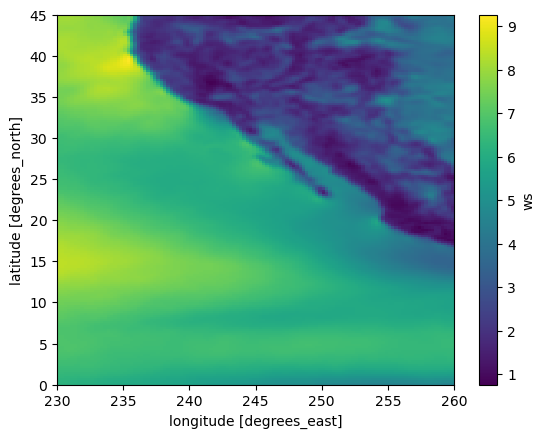

In [14]:
ws_mean_map.plot()

## 3. For comparison, do same procedure with the kerchunk JSON reference

In [15]:
earthaccess.login()
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [16]:
%%time
data = xr.open_dataset(
    "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ccmp/open/L4_V3.1/docs/CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json",
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)
data

CPU times: user 875 ms, sys: 113 ms, total: 988 ms
Wall time: 4.8 s


<xarray.Dataset> Size: 775GB
Dimensions:    (time: 46696, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [17]:
%%time
## Test subsetting:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("2001-01-01"), np.datetime64("2002-01-01"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

CPU times: user 309 ms, sys: 15.9 ms, total: 325 ms
Wall time: 324 ms


<xarray.Dataset> Size: 505MB
Dimensions:    (time: 1461, latitude: 180, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 480B 230.1 230.4 230.6 ... 259.4 259.6 259.9
  * time       (time) datetime64[ns] 12kB 2001-01-01 ... 2002-01-01
Data variables:
    ws         (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    nobs       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [18]:
%%time
# Test computing mean windspeed over the subsetting region:
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 56.9 s, sys: 3.08 s, total: 59.9 s
Wall time: 1min 5s


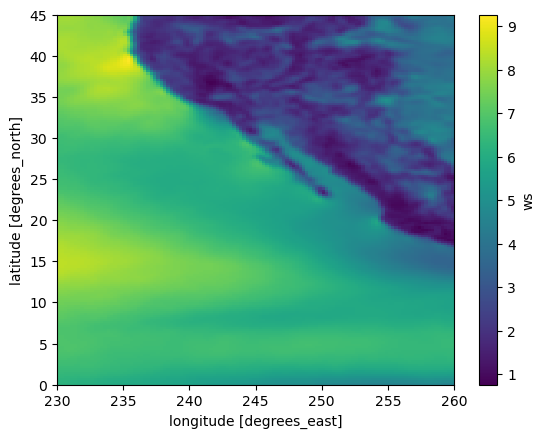

In [19]:
ws_mean_map.plot()